## PREDICTION TASK 2 (Using the Weekly Data)

This model uses the weekly dataset that has new additional features like Weekly_Avg_Pct_Home, Incident_Rate_Last_week, Incident_Rate_Pct_Change_Last_week. However due to categorizing the data week by week, the input dataset is smaller than the daily dataset. The goal of the model is to predict top 20 states that will see most change in incident rate over a period of 2 weeks between May 10-24.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import mizani
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import sklearn.model_selection as CrossValidate
from matplotlib.pyplot import rcParams
from sklearn.metrics import mean_absolute_error

plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from patsy import dmatrices
import statsmodels.api as sm


print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.1.0
Eager execution: True


In [2]:
## Define Poisson loss and gradient

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = model(x, training=training)

    return tf.keras.losses.poisson(y,logits)


## Gradient tape lets TF know with respect to what to take gradients
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [3]:
#standardizer function which standardizes the numerical data and encodes the categorical data with One hot encoding
def standardize_fit2 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = OneHotEncoder(sparse=False)
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    categories= encoder.categories_

    return categories, scaler, encoder 

def standardize_transfrom2( Xin, scaler, encoder):
    X = Xin.values[:,1:]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X)
    return np.concatenate((X_std_cat, X_std_num),axis=1)

In [4]:
#importing the train set
X_tr = pd.read_csv('../data/X_weekly_tr.csv')   
y_tr = pd.read_csv('../data/y_weekly_change_tr.csv') 
print(X_tr.shape)
print(y_tr.shape)

#importing the test set
X_te = pd.read_csv('../data/X_weekly_te.csv')   
y_te = pd.read_csv('../data/y_weekly_change_te.csv') 
print(X_te.shape)
print(y_te.shape)

(436, 6)
(436, 2)
(104, 6)
(104, 2)


In [5]:
train_timestamps = X_tr['Date'].values
test_timestamps = X_te['Date'].values

In [6]:
X_tr = X_tr.drop(['Date'], axis=1)
y_tr = y_tr.drop(['Date'], axis=1)
X_te = X_te.drop(['Date'], axis=1)
y_te = y_te.drop(['Date'], axis=1)

In [7]:
# just to make sure if any Null is left
print ("number of nulls left in X_tr is ", len(X_tr[X_tr.isnull().values == True].head()))
print ("number of nulls left in X_te is ", len(X_te[X_te.isnull().values == True].head()))

number of nulls left in X_tr is  0
number of nulls left in X_te is  0


In [8]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Province_State                      436 non-null    object 
 1   Weekly_Avg_Pct_Home                 436 non-null    float64
 2   Elapsed_Days                        436 non-null    int64  
 3   Incident_Rate_Last_week             436 non-null    float64
 4   Incident_Rate_Pct_Change_Last_week  436 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 17.2+ KB


In [9]:
X_tr.describe()

,Weekly_Avg_Pct_Home,Elapsed_Days,Incident_Rate_Last_week,Incident_Rate_Pct_Change_Last_week
count,436.000000,436.000000,436.000000,436.000000
mean,36.968382,29.350917,115.964551,2.897401
std,6.596189,17.847071,212.076329,4.995127
min,21.758841,0.000000,0.003449,0.000000
25%,32.912088,14.000000,6.271094,0.333152
50%,37.020951,29.000000,45.478209,0.857425
75%,41.261225,45.000000,121.404014,3.256551
max,61.343387,67.000000,1626.514549,34.000000


In [10]:
y_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 1 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Weekly_Incident_Rate_Pct_Change  436 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


In [11]:
y_tr.describe()

,Weekly_Incident_Rate_Pct_Change
count,436.000000
mean,1.753532
std,3.187174
min,0.000000
25%,0.254785
50%,0.500422
75%,1.890815
max,31.000000


In [12]:
#standardizing the train and test data from the previously fitted standardizers
# using the standardized data with sparse matrix for the categorized data (One hot encoded)
categories, scaler, encoder2 = standardize_fit2(X_tr)
X_tr_std = standardize_transfrom2(X_tr, scaler, encoder2)
X_te_std = standardize_transfrom2(X_te, scaler, encoder2)

print(X_te_std.shape)
print(X_tr_std.shape)

(104, 56)
(436, 56)


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr_std,y_tr.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_te_std,y_te.values))

batch_size = 8

#train_dataset_house = train_dataset_house.shuffle(buffer_size=len(X_tr))
train_dataset = train_dataset.batch(batch_size)
#test_dataset_house = test_dataset_house.shuffle(buffer_size=len(X_te))
test_dataset= test_dataset.batch(batch_size)

X,y = next(iter(train_dataset))
_, num_features = X.shape

In [14]:
early_stop_delta = 0.5
early_stop_patience = 10
num_epochs = 300

models =[]

model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim= num_features, activation="sigmoid"), 
  tf.keras.layers.Dense(32, activation="sigmoid"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])
models.append(model)

# model = tf.keras.Sequential([
#   tf.keras.layers.Dense(64, input_dim= num_features, activation="relu"), 
#   tf.keras.layers.Dense(32, activation="relu"),
#   tf.keras.layers.Dense(1, activation="relu")
# ])
# models.append(model)

In [15]:
## Training Model
histories= []
scores= []

best_score = np.Inf 
m = 0
for model in models:
    history= {}
    train_loss_results = []
    train_accuracy_results = []
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.MeanAbsoluteError()
        
        # Training loop - using batches of 8
        for x, y in train_dataset:
            # Optimize the model
            loss_value, grads = grad(model, x, y)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))       

            # Track progress
            epoch_loss_avg.update_state(loss_value)  # Add current batch loss
            epoch_accuracy.update_state(y, model(x, training= True))

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

    history['loss'] = train_loss_results
    history['mae'] = train_accuracy_results
    y_pred = model(x, training= False)
    score = mean_absolute_error(y_true= y, y_pred= y_pred)
    histories.append(history)
    scores.append(score)    
    if score < best_score:
        best_score = score
        best_model = model
        best_history = history
        best_model_index = m
    m += 1

print("Mean Abosulte Error score of the best model: %0.5f" % best_score )
print("best model index is:", m)
print("best model:", best_model.summary())

Mean Abosulte Error score of the best model: 0.00993
best model index is: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3648      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
_________________________________________________________________
best model: None


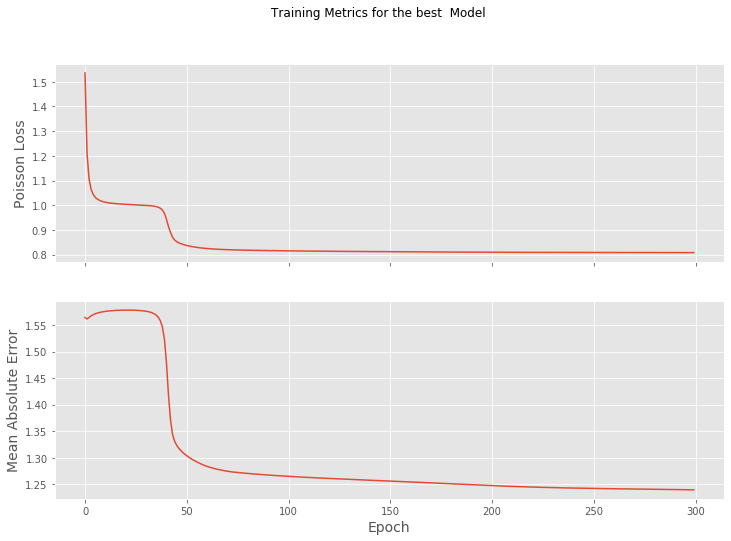

In [16]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics for the best  Model')

axes[0].set_ylabel("Poisson Loss", fontsize=14)
axes[0].plot(best_history['loss'])

axes[1].set_ylabel("Mean Absolute Error", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(best_history['mae'])
plt.show()

In [17]:
def x_with_ppreds(X,model):
    x_df = pd.DataFrame(X.numpy())
    p_preds = (model(X,training=False)).numpy()
    x_df['p_pred'] = p_preds
    return x_df

In [18]:
## Compute test loss for the best model
test_loss_results = []
test_accuracy_results = []

model = best_model
test_loss_avg = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.MeanAbsoluteError()
for (x, y) in test_dataset:
    # training=False is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout). = 
    test_loss_avg.update_state(loss(model, x, y, training=False))
    test_accuracy.update_state(y, model(x, training=False))
test_loss_results.append(test_loss_avg.result())
test_accuracy_results.append(test_accuracy.result())

In [19]:
print("Test set MAE of best Model: {:.5}".format(test_accuracy_results[0]))
print("Test set Poisson Loss of best Model: {:.5}".format(test_loss_results[0]))

Test set MAE of best Model: 0.037926
Test set Poisson Loss of best Model: 0.41765


In [20]:
pred_df = pd.concat(x_with_ppreds(x,model) for (x,y) in test_dataset)
#pred_df

In [4]:
values_pred,indices_pred = tf.math.top_k(pred_df['p_pred'],k=30)
indices_pred = np.asarray(indices_pred)

values,indices = tf.math.top_k(y_te['Weekly_Incident_Rate_Pct_Change'],k=30)
indices = np.asarray(indices)

top20 = pd.DataFrame()
top20['Predicted_Province_State'] = pd.Series([X_te.loc[i,'Province_State'] for i in indices_pred]).unique()
top20['Actual_Province_State'] = pd.Series([X_te.loc[i,'Province_State'] for i in indices]).unique()

#print([X_te.loc[i,'Province_State'] for i in indices])
#print(values)

NameError: name 'tf' is not defined

In [ ]:
print('Top 20 States with highest incident rate change between May 10 to May 24')
top20

Top 20 States with highest incident rate change between May 10 to May 24


NameError: name 'top20' is not defined

In [2]:
true = top20['Predicted_Province_State'].isin(top20['Actual_Province_State'])
print(len(np.where(true == True)[0]),'out of Top 20 States are predicted correctly')

NameError: name 'top20' is not defined

In [3]:
#test 
df['isin'] =df.apply(lambda row: row['coname1'] in row['coname2'],axis=1)

NameError: name 'df' is not defined